# Chord Recognition Algorithm

Finding chord names from a given audio file.

## Files

"Chords.m4a" and "Chords.ogg" = audio file of chords being played on a piano

"Chord_Progressions.pdf" = written out chords from the audio files, the number in the following variable names correspond with the measure numbers in this file (i.e. c6 = segment of the audio file featuring the chord from measure 6)

## Background

#### General:
We both have prior knowledge in music theory concepts through the College of Fine Arts.

#### General terms:

Pitch classes = all pitches within an octave (C C#/Db D D#/Eb E F F#/Gb G G#/Ab A A#/Bb B)

Whole Step =  Looking at a piano keyboard, notes are two keys away from each other

Half Step = Looking at a piano keyboard, notes are one key away from each other

Major Triad = A three note chord where given a base, the second note is four half steps above the base, and the third note is four half steps above the second note

Minor Triad = A three note chord where given a base, the second note is three half steps above the base, and the third note is four half steps above the second note

Dominant 7th (can be represented with 7) = A four note chord where given a base, the second note is four half steps above the base, the third note is three half steps above the second note, and the fourth note is three half steps above the third note.

Half Diminished (can be represented with ø) = A four note chord where given a base, the second note is three half steps above the base, the third note is three half steps above the second note, and the fourth note is four half steps above the third note.

Diminished (can be represented with o7) = A four note chord where given a base, each following note is three half steps above the preceding note.

#### Readings:

- ["Automatic Chord Recognition for Music Classification and Retrieval"][1] 
- ["Visualizing Sounds Using Librosa Machine Learning Library!"][2] (We adapted some code from here to display the chromagraphs)
- ["An Expert Ground-Truth Set for Audio Chord Recognition and Music Analysis"][3]
- [From class: Lecture 18][4]
- Fundamentals of Music Processing by Meinard Müller - Chapter 5: Chord Recognition

[1]: https://users.ece.cmu.edu/~hengtzec/papers/icme08_chord.pdf "Automatic Chord Recognition for Music Classification and Retrieval"
[2]: https://www.analyticsvidhya.com/blog/2021/06/visualizing-sounds-librosa/ "Visualizing Sounds Using Librosa Machine Learning Library!"
[3]: https://ismir2011.ismir.net/papers/OS8-1.pdf "An Expert Grount-Truth Set for Audio Chord Recognition and Music Analysis"
[4]: https://www.cs.bu.edu/fac/snyder/cs583/Lectures/Lecture%2018.pdf "Lecture 18"

In [2]:
# General useful imports
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio

from scipy import signal
from scipy.signal import find_peaks, windows

%matplotlib inline


# Basic audio parameters

SR = 22050 #  sample rate default for Librosa


# Round to 4 decimal places
def round4(x):
    return np.around(x,4)  

## Code to Display a Melody File and Create a Spectrogram and Chromagraph


In [3]:
def displaySignal(x, sr=SR, title='Signal X'):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.plot([0,librosa.get_duration(x)],[0,0],linewidth=1,color='k')
    plt.grid() # gridlines
    librosa.display.waveshow(x,sr=sr)
    plt.show() 

### Displays Chroma of signal

In [6]:
def displaySpectroChroma(x, sr=SR, y_axis='linear'): #y_axis="log"
    
    S = np.abs(librosa.stft(x)) # calculate the 2D spectrogram
    Sdb = librosa.amplitude_to_db(S, ref=np.max) # will show power spectrum in heatmap

    plt.figure(figsize=(12,6))
    plt.title("Spectrogram")
    librosa.display.specshow(Sdb, sr=SR, x_axis='time', y_axis=y_axis)
    plt.colorbar(format='%+2.0f dB')
    plt.show()


    S = np.abs(librosa.stft(x, n_fft=4096))**2
    chroma = librosa.feature.chroma_stft(S=S, sr=SR)

    plt.figure(figsize=(12,6))
    plt.title("Chromagraph")
    img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.show()

# Graphs for Chord Audios

Linsy recorded all the chords found in "Chords.m4a" on a piano in a CFA practice room :)

In [7]:
try:
    x, sr = librosa.load("Chords.m4a")
except:
    x, sr = librosa.load("Chords.ogg") # in case .m4a doesn't work

/Users/linsywang/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


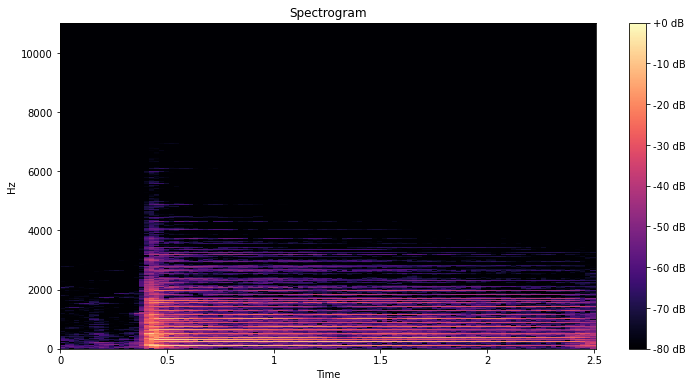

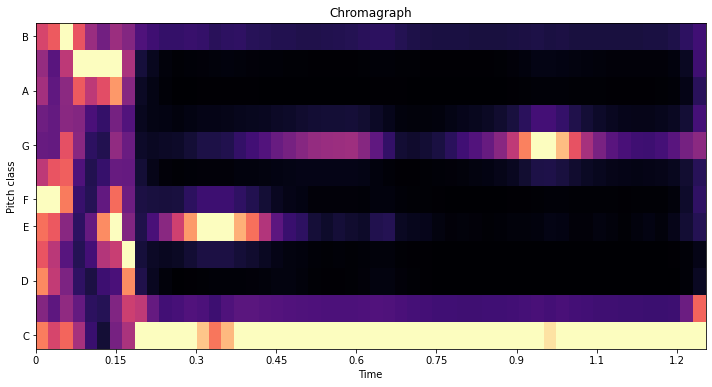

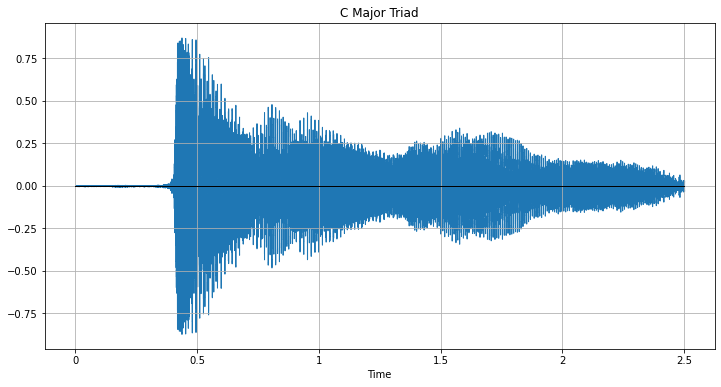

In [8]:
c1 = x[int(4.5*SR):int(7*SR)]

displaySpectroChroma(x = c1)

displaySignal(c1, title="C Major Triad")
Audio(c1, rate=sr)

The first issue we ran into was that noise at the beginning and end of a chord sound can really mess with the chromagraph. We manually removed the beginning and end of the audio file so that the readings could be more accurate.

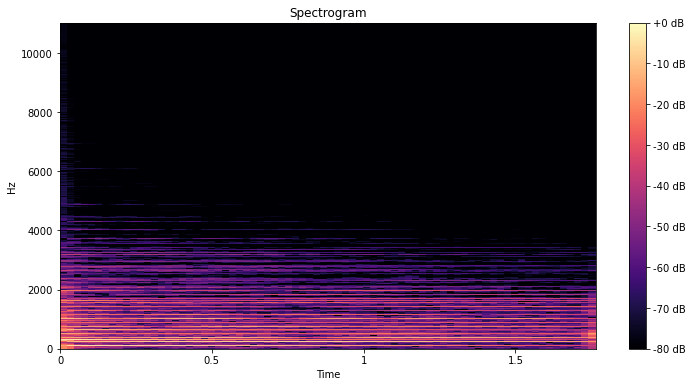

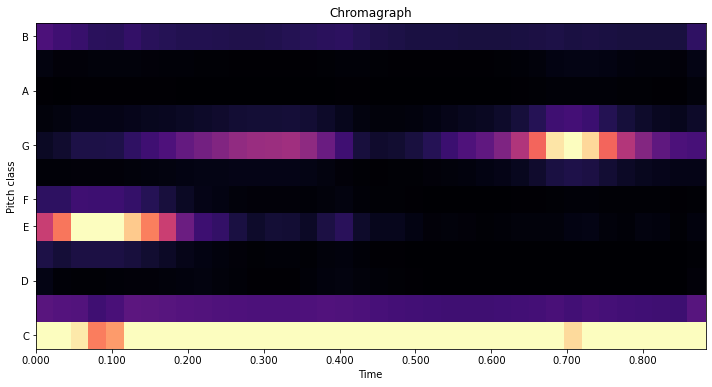

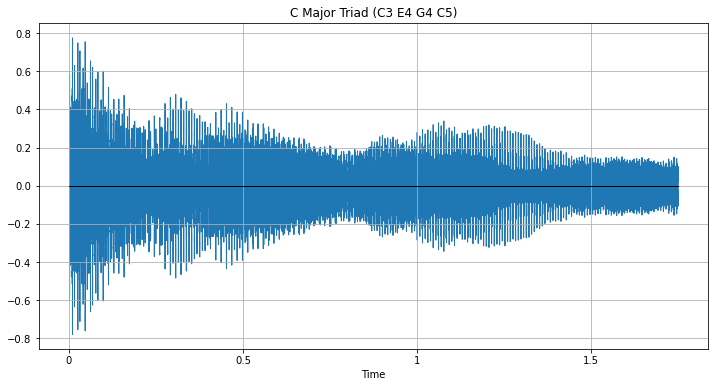

In [9]:
c1 = x[int(5*SR):int(6.75*SR)]

displaySpectroChroma(x = c1)

displaySignal(c1, title="C Major Triad (C3 E4 G4 C5)")
Audio(c1, rate=sr)



In [20]:
# create a dictionary of pitch class notes
notenames = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]


Note	Chroma Energy
C 	 1.0
C# 	 0.27238977
D 	 0.037970424
D# 	 0.12738807
E 	 0.5466125
F 	 0.17022216
F# 	 0.017183548
G 	 0.07087622
G# 	 0.025209859
A 	 0.0074069216
A# 	 0.031277575
B 	 0.24127382


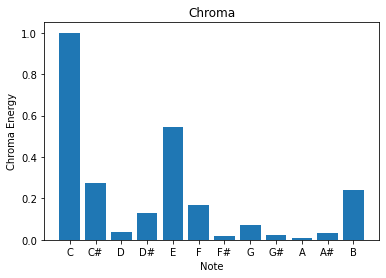

In [21]:
# returns chroma as a numpy array of length 12
def get_chroma(x,sr=SR,window_size=4096):
    # power spectrum
    #c = librosa.feature.chroma_stft(y=x, sr=sr,n_fft=window_size,hop_length=len(x)+1)
    
    # magnitude spectrum
    #S = np.abs(librosa.stft(x))
    #c = librosa.feature.chroma_stft(S=S, sr=sr,n_fft=window_size,hop_length=len(x)+1)
    
    # Use a pre-computed power spectrogram 
    S = np.abs(librosa.stft(x, n_fft=window_size))**2
    c = librosa.feature.chroma_stft(S=S, sr=sr,n_fft=window_size,hop_length=len(x)+1)
    
    return (c.T)[0]

c = get_chroma(c1)

print("\nNote\tChroma Energy")
for k in range(12):
    print(notenames[k],"\t", c[k])

plt.title("Chroma")
x = notenames
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, c)
plt.xlabel("Note")
plt.ylabel("Chroma Energy")
plt.xticks(x_pos, x)
plt.show()


In this bar graph, you can see that while C and E were correctly picked out, we have some false flags like C# and B. Two possible causes of this are:

(a) Extra noise: Since we weren't recording in a soundproof environment with high-quality mics, the algorithm is bound to produce some incorrect readings due to low-quality audio.

(b) Overtones: For example, E was one of our main detected pitches. A prominent overtone of a note is typically seven half steps above that note's pitch. In this case, seven half steps above E is B.
    


In [22]:
def distance(chroma, template, kind='L2'): # default is L2 norm
    if(kind == 'L1'):
        return np.sum(np.abs(chroma-template))
    elif(kind == 'L2'):
        return (np.sum((chroma-template)**2))**0.5
    elif(kind == 'CD'): # Correlation Distance:  1 + correlation
        s = np.std(chroma) # must account for inputs with all 0's
        sn = np.std(template)
        if(np.isclose(s,0) or np.isclose(sn,0)):
            return 0.0
        else:
            return 1.0 - (((chroma - np.mean(chroma)) @ (template - np.mean(template))) / (len(chroma) * s * sn))              
    else:
        return None

The original code from Lecture 18 covers the 12 major and minor triads. In addition to those, we expanded the chord templates to cover dominant seventh, half diminished, and fully diminished chords as well.

In [25]:
# Make the chord templates for 12 major and 12 minor triads. (from Muller's book)
def generate_chord_templates(nonchord=False):
    """Generate chord templates of major and minor triads, dominant seventh, half diminished, and diminished
    """
    # template based on C
    mode_templates = [(np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]), "M "), # major triad
                      (np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]), "m "), # minor triad
                      (np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]), "7 "), # dominant 7th (major triad + minor 7th)
                      (np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]), "ø"), # half diminished (diminished triad + minor 7th)
                      (np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]), "o7")] # fully diminished (diminished triad + diminished 7th)
    
    chord_templates = []
    chord_names = []
    
    for i in range(len(mode_templates)):
        template, mode = mode_templates[i]
        for k in range(len(notenames)):
            chord_names.append(notenames[k] + mode)
            chord_templates.append(np.roll(template, k))
        
    chord_names = np.array(chord_names)
    chord_templates = np.array(chord_templates)
    return chord_names, chord_templates

chord_names, chord_templates = generate_chord_templates()

print("Chord\t Template")
print("\t  C C#D D#E F F#G G#A A#B")
for i in range(len(chord_templates)):
    print(chord_names[i], "\t", chord_templates[i])
    


Chord	 Template
	  C C#D D#E F F#G G#A A#B
CM  	 [1 0 0 0 1 0 0 1 0 0 0 0]
C#M  	 [0 1 0 0 0 1 0 0 1 0 0 0]
DM  	 [0 0 1 0 0 0 1 0 0 1 0 0]
D#M  	 [0 0 0 1 0 0 0 1 0 0 1 0]
EM  	 [0 0 0 0 1 0 0 0 1 0 0 1]
FM  	 [1 0 0 0 0 1 0 0 0 1 0 0]
F#M  	 [0 1 0 0 0 0 1 0 0 0 1 0]
GM  	 [0 0 1 0 0 0 0 1 0 0 0 1]
G#M  	 [1 0 0 1 0 0 0 0 1 0 0 0]
AM  	 [0 1 0 0 1 0 0 0 0 1 0 0]
A#M  	 [0 0 1 0 0 1 0 0 0 0 1 0]
BM  	 [0 0 0 1 0 0 1 0 0 0 0 1]
Cm  	 [1 0 0 1 0 0 0 1 0 0 0 0]
C#m  	 [0 1 0 0 1 0 0 0 1 0 0 0]
Dm  	 [0 0 1 0 0 1 0 0 0 1 0 0]
D#m  	 [0 0 0 1 0 0 1 0 0 0 1 0]
Em  	 [0 0 0 0 1 0 0 1 0 0 0 1]
Fm  	 [1 0 0 0 0 1 0 0 1 0 0 0]
F#m  	 [0 1 0 0 0 0 1 0 0 1 0 0]
Gm  	 [0 0 1 0 0 0 0 1 0 0 1 0]
G#m  	 [0 0 0 1 0 0 0 0 1 0 0 1]
Am  	 [1 0 0 0 1 0 0 0 0 1 0 0]
A#m  	 [0 1 0 0 0 1 0 0 0 0 1 0]
Bm  	 [0 0 1 0 0 0 1 0 0 0 0 1]
C7  	 [1 0 0 0 1 0 0 1 0 0 1 0]
C#7  	 [0 1 0 0 0 1 0 0 1 0 0 1]
D7  	 [1 0 1 0 0 0 1 0 0 1 0 0]
D#7  	 [0 1 0 1 0 0 0 1 0 0 1 0]
E7  	 [0 0 1 0 1 0 0 0 1 0 0 1]
F7  	 [1 0 0 1 0 

Chroma [1.         0.27143088 0.03829506 0.1302265  0.55295986 0.17316025
 0.01740178 0.06799602 0.02491138 0.00752203 0.03149268 0.24490102] 



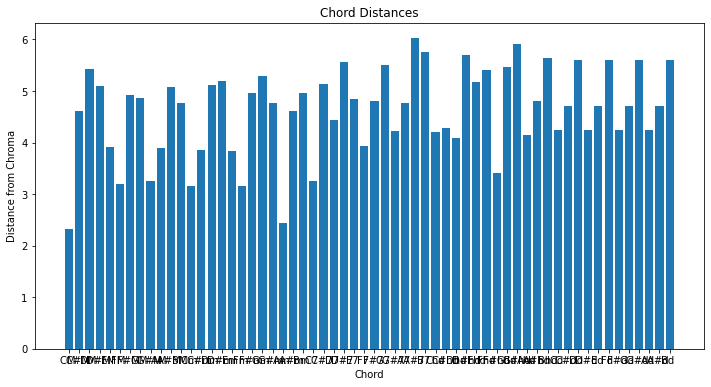


Closest template:  CM  with distance 2.3184


In [12]:
# apply distance function to chroma and all possible chords, and print array of 24 distances
def apply_chord_templates(chroma, dist="L2", chord_names=chord_names, chord_templates=chord_templates, display=True):
#     if(display):
#         print("Chord\t Score")
    n = 0
    min_score = 1000000
    scores = []
    
    for k in range(len(chord_names)):
        s = distance(chroma, chord_templates[k], kind=dist)
        scores.append(s)
#         if(display):
#             print( chord_names[k], "\t", s )
        if(s < min_score):
            n = k
            min_score = s
            
    if(display):
        plt.figure(figsize=(12,6))
        plt.title("Chord Distances")
        x = chord_names
        x_pos = [i for i, _ in enumerate(x)]
        plt.bar(x_pos, scores)
        plt.xlabel("Chord")
        plt.ylabel("Distance from Chroma")
        plt.xticks(x_pos, x)
        plt.show()

        print("\nClosest template: ",chord_names[n], "with distance", round4(min_score))
        
    return (chord_names[n],min_score)

ch = get_chroma(c1)

print("Chroma", ch,"\n")

(_,_) = apply_chord_templates(ch,dist="L1")

Next, we tried different voicings of C Major to see if it would affect our results. We wrote this function so that we wouldn't have to repeat a bunch of code:

In [13]:
# prints spectrogram, chromagraph, signal, audio, and algorithm guess for a given audio file input 
def printResults(signal, title = "placeholder title"):
    displaySpectroChroma(x = signal)
    displaySignal(signal, title = title)
    display(Audio(signal, rate=sr))
    (chord, _) = apply_chord_templates(get_chroma(signal),dist="L1", display = False)
    print("This chord is probably", chord) 

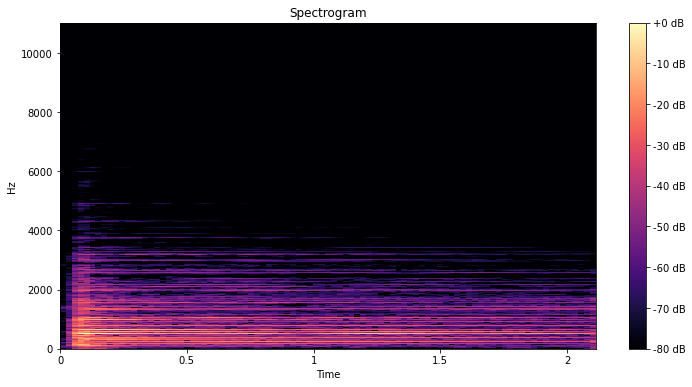

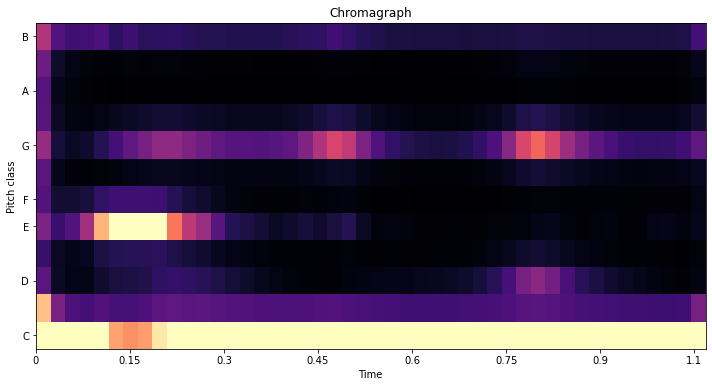

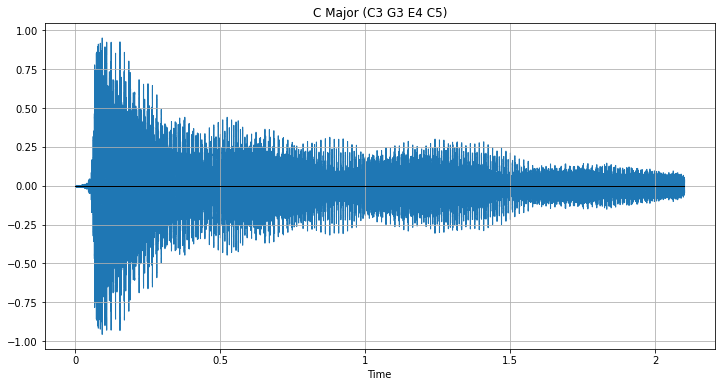

This chord is probably CM 


In [17]:
c2 = x[int(7.6*SR):int(9.7*SR)]
printResults(c2, title = "C Major (C3 G3 E4 C5)")

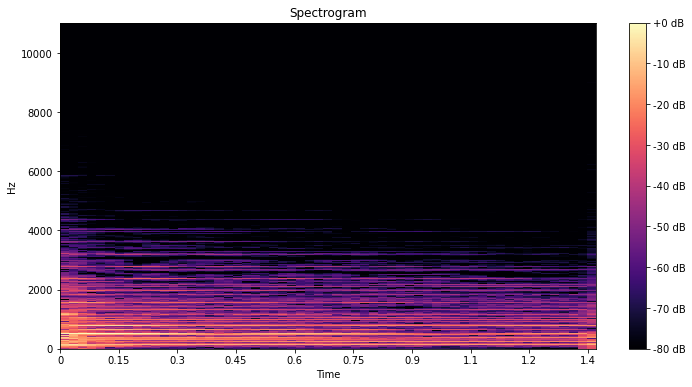

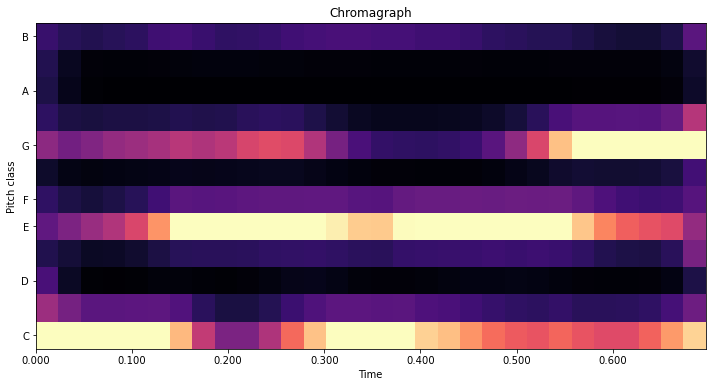

This chord is probably CM 


In [18]:
c3 = x[int(10.4*SR):int(11.75*SR)]
printResults(c3, title = "C Major (C3 E3 C4 G4)")

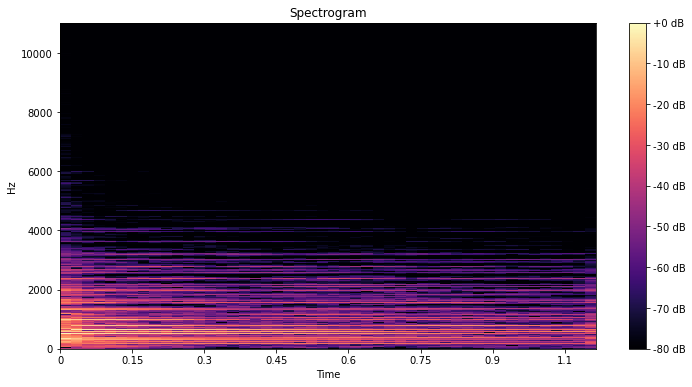

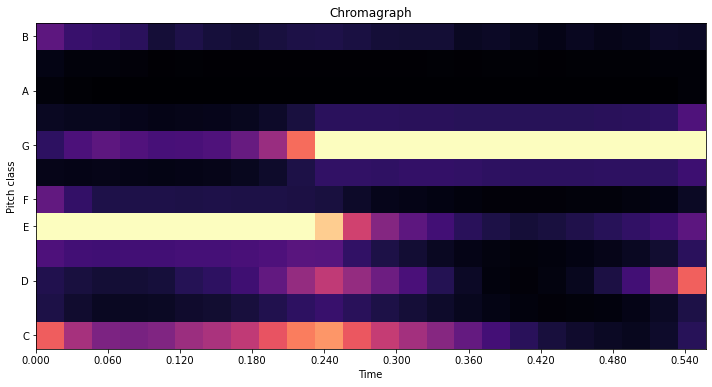

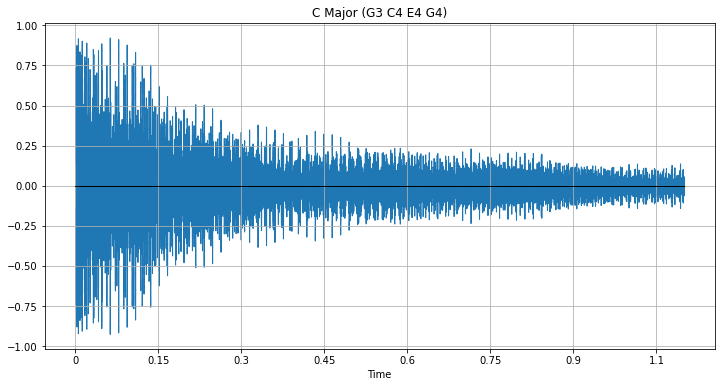

This chord is probably CM 


In [19]:
c4 = x[int(13*SR):int(14.1*SR)]
printResults(c4, title = "C Major (G3 C4 E4 G4)")

Looks like C major registers correctly no matter what the voicing or inversion is! We did notice that results were a little off before cutting noise from the audio (getting things like A minor, B half diminished, and D minor) but it ultimately ended up working when we cut out the noise. This isn't going to be an issue until we have to analyze chord changes, so we're not going to deal with that just yet. Onto some different types of C chords!

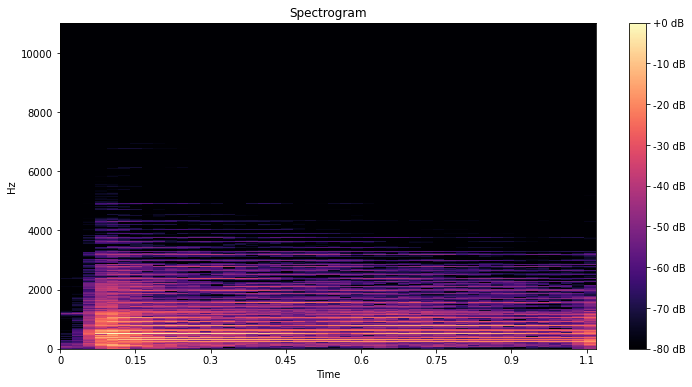

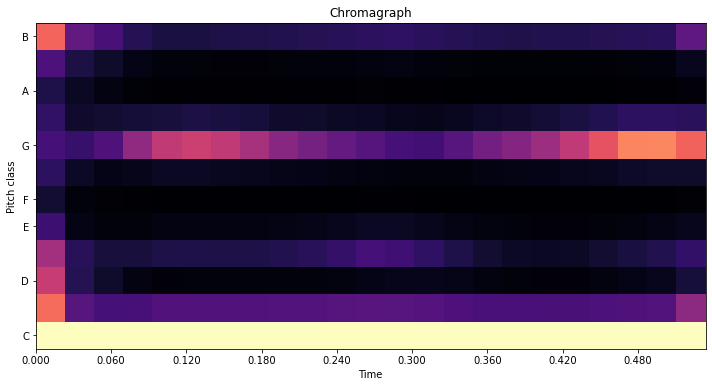

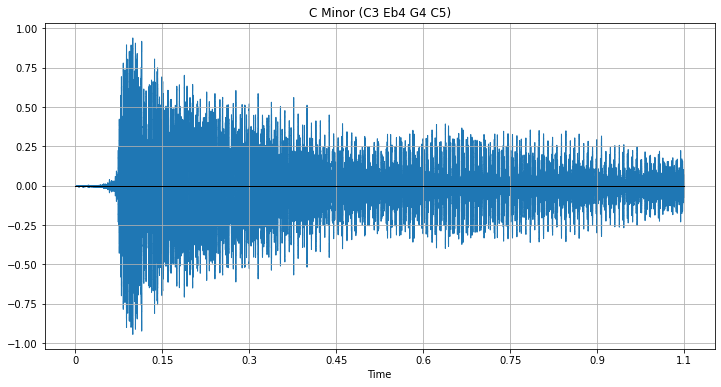

This chord is probably Cm 


In [20]:
c5 = x[int(20.45*SR):int(21.5*SR)]
printResults(c5, title = "C Minor (C3 Eb4 G4 C5)") # without cut: A# half diminished

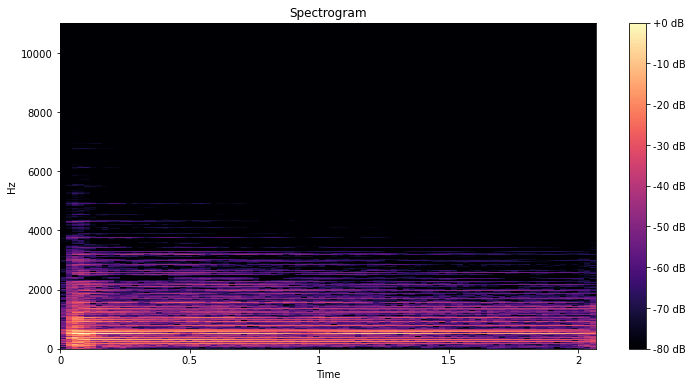

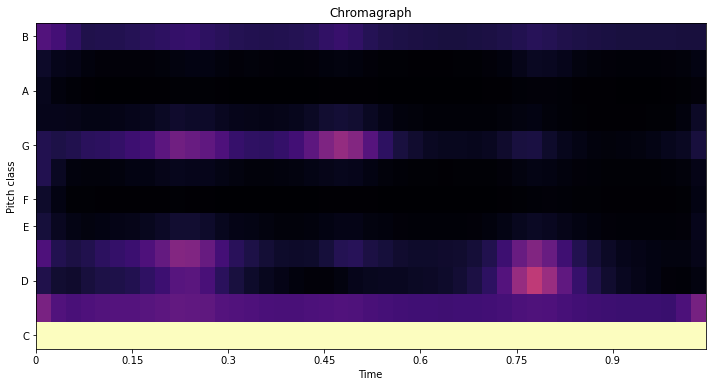

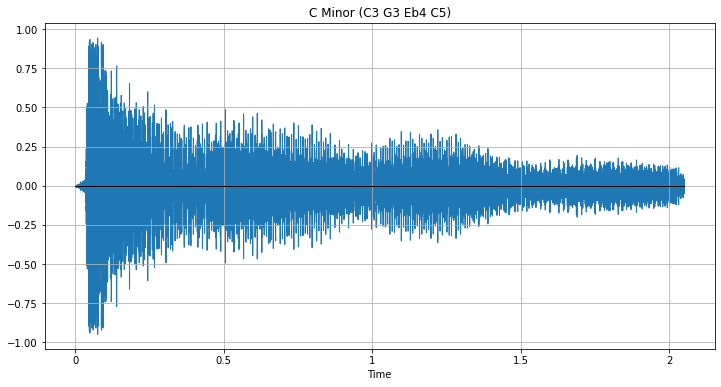

This chord is probably Cm 


In [21]:
c6 = x[int(22.7*SR):int(24.75*SR)]
printResults(c6, title = "C Minor (C3 G3 Eb4 C5)") # without cut: Gm

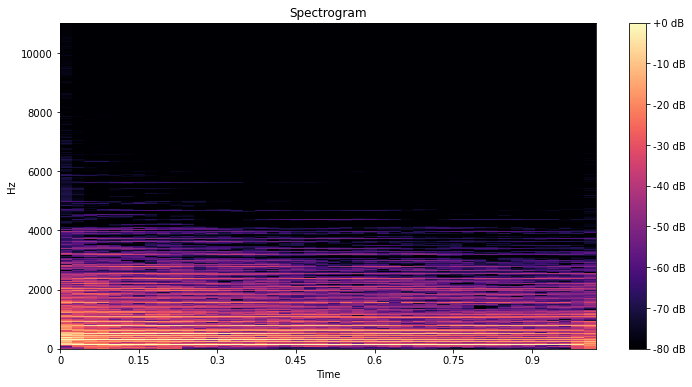

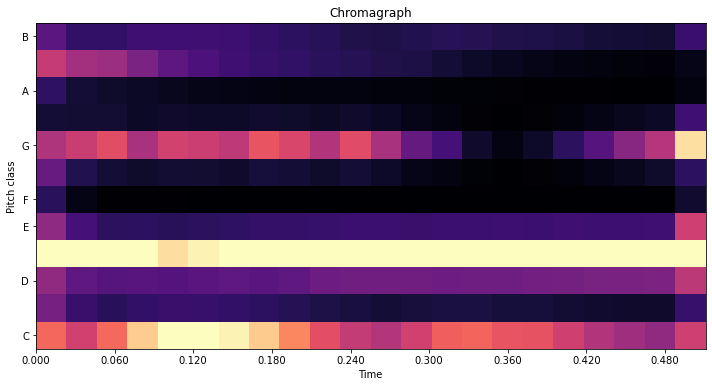

This chord is probably Cm 


In [22]:
c7 = x[int(25.4*SR):int(26.4*SR)]
printResults(c7, title = "C Minor (C3 Eb3 C4 G4)") # without cut: B7

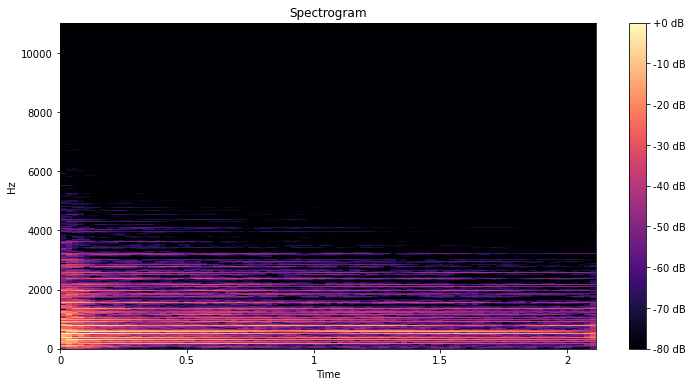

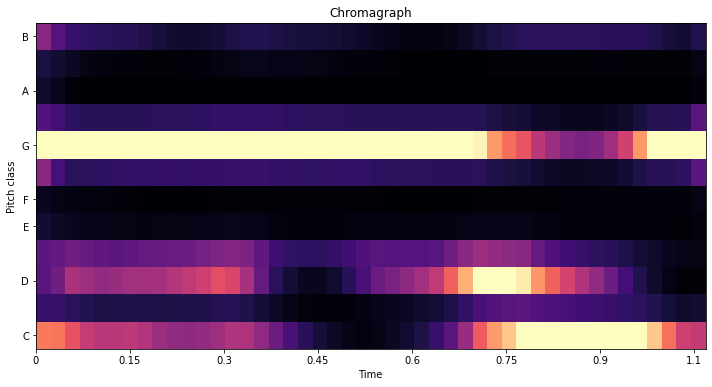

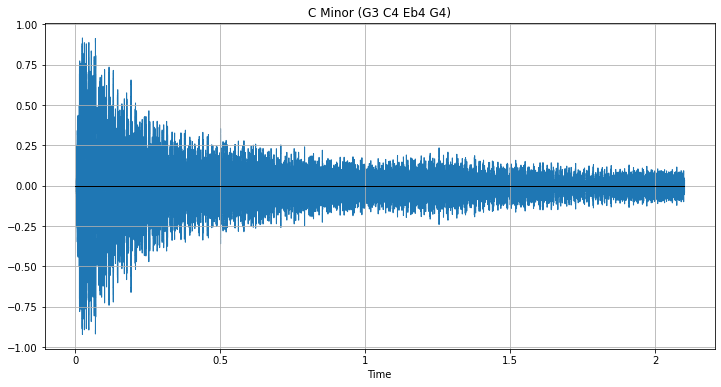

This chord is probably Cm 


In [23]:
c8 = x[int(30.2*SR):int(32.3*SR)]
printResults(c8, title = "C Minor (G3 C4 Eb4 G4)") # without cut: G#m

The algorithm's been surprisingly accurate for C major and C minor. Now, how will it behave when we move on to new material?

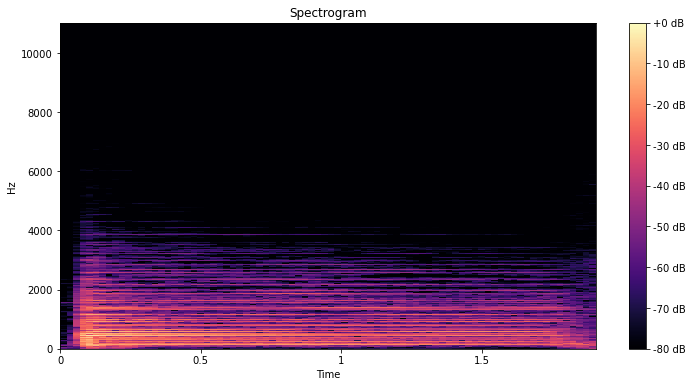

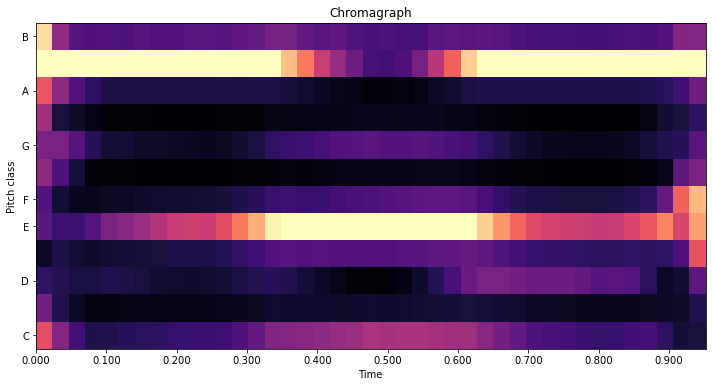

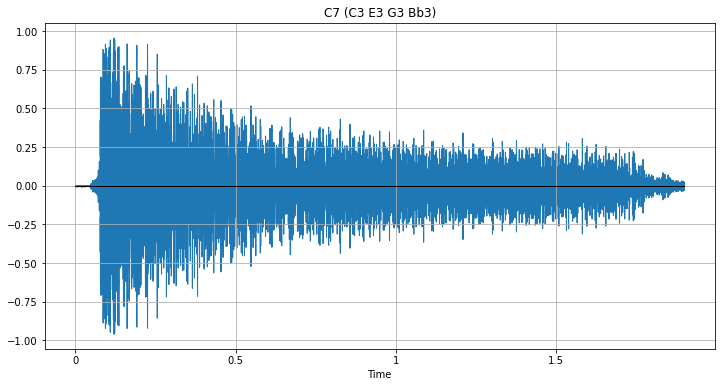

This chord is probably C7 


In [24]:
c9 = x[int(35.5*SR):int(37.4*SR)] 
printResults(c9, title = "C7 (C3 E3 G3 Bb3)")

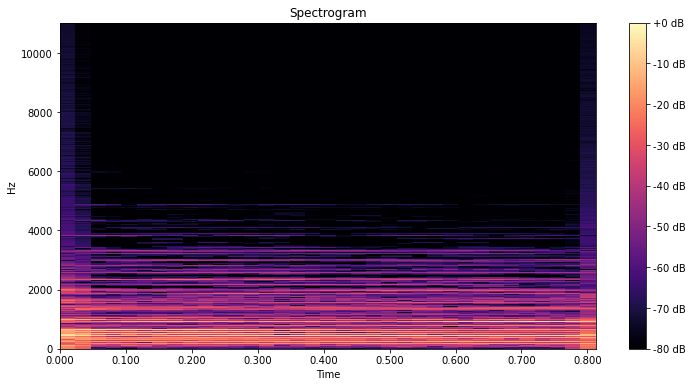

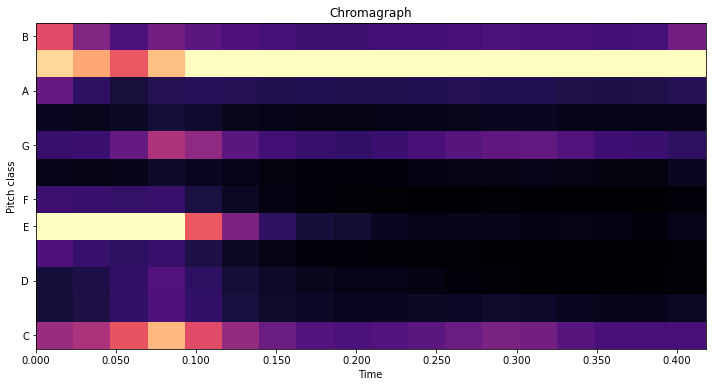

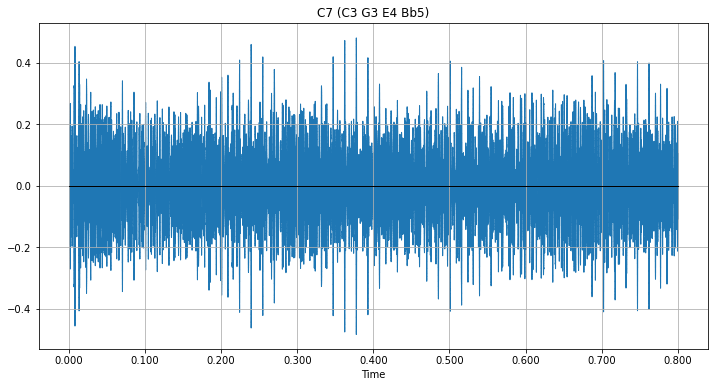

This chord is probably C7 


In [25]:
c10 = x[int(38.1*SR):int(38.9*SR)]
printResults(c10, title = "C7 (C3 G3 E4 Bb5)") # without cut: E7

This one required a lot more cut audio than most of the other chords in order for C7 to sound clearly. It seems like writing an algorithm that automatically cuts audio for us will be difficult.

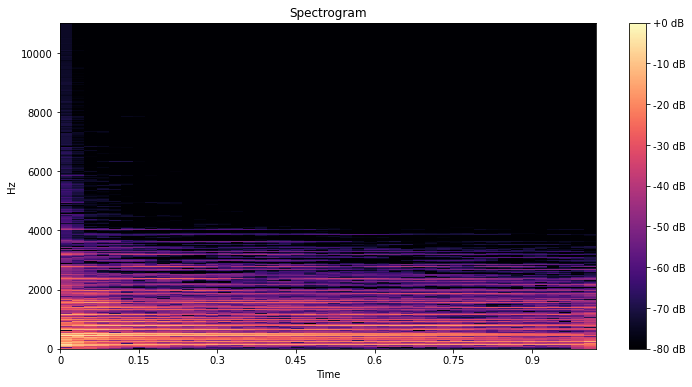

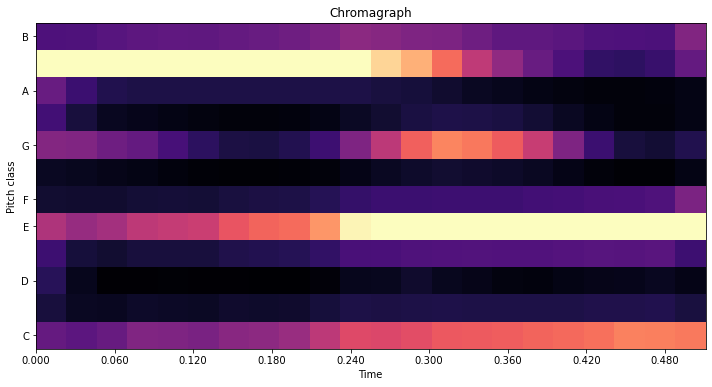

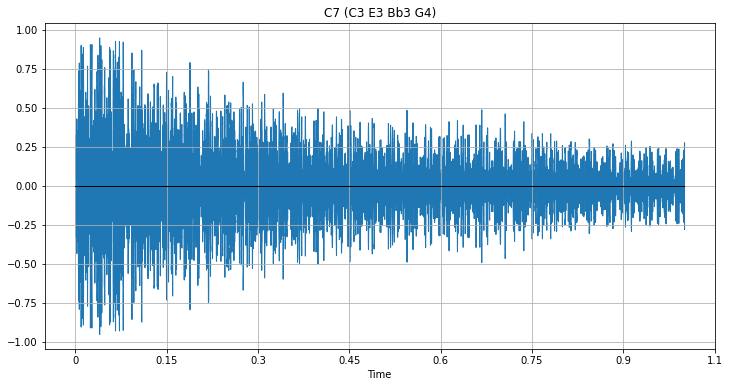

This chord is probably C7 


In [26]:
c11 = x[int(40.4*SR):int(41.4*SR)]
printResults(c11, title = "C7 (C3 E3 Bb3 G4)") # without cut: Am

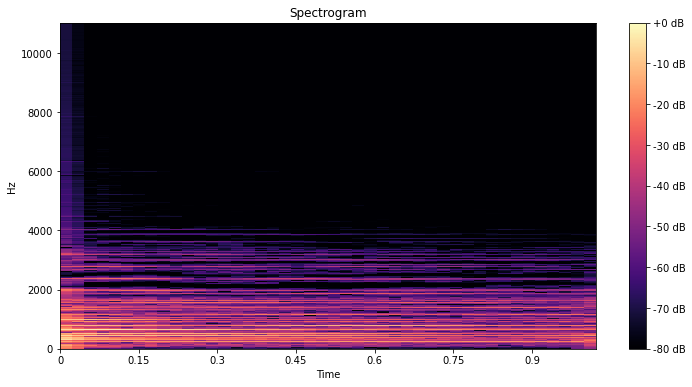

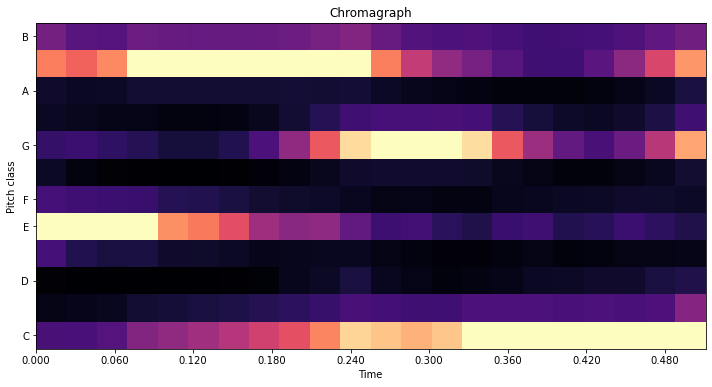

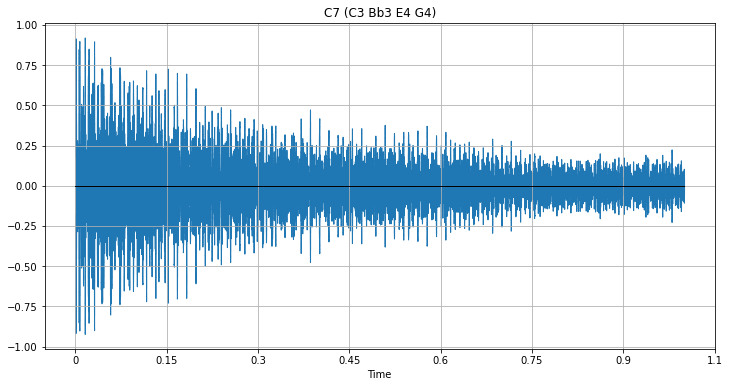

This chord is probably C7 


In [27]:
c12 = x[int(42.8*SR):int(43.8*SR)]
printResults(c12, title = "C7 (C3 Bb3 E4 G4)") # without cut: F major

C7 seemed to go pretty well, too. We think it's the prominence of the seventh chord that makes it easier to detect for the algorithm; you can see the Bb is very bright in each example.

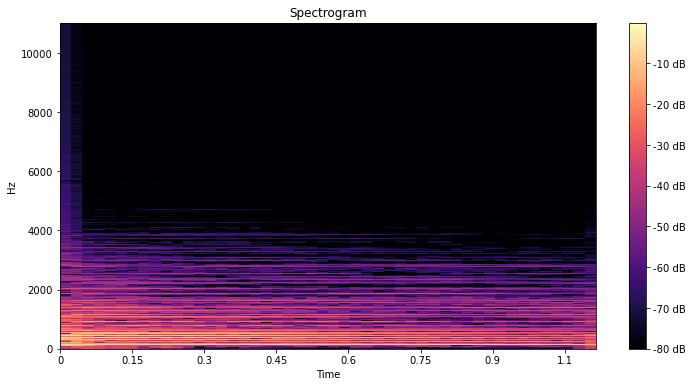

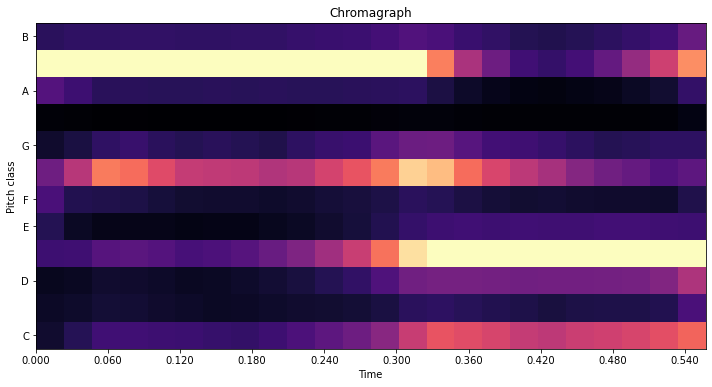

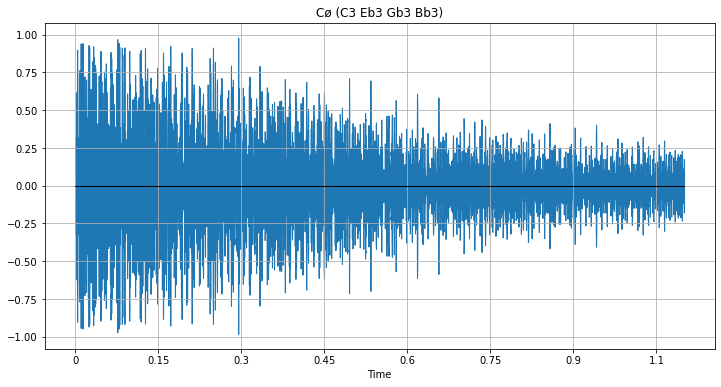

This chord is probably D#m 


In [28]:
c13 = x[int(47.9*SR):int(49*SR)]
printResults(c13, title = "Cø (C3 Eb3 Gb3 Bb3)") # without cut: F half diminished

This is where we start running into trouble. D# is enharmonic with Eb, where the notes of an Eb minor triad are:

Eb Gb Bb

However, the notes of a C half-diminished triad are:

C Eb Gb Bb

So you can see that the algorithm was confused by the overlap. Indeed, it seems like C isn't coming out very well at all. One suggestion we had received when we pitched this project was to give the program the bass note, which would definitely have helped in this case. We'll try more test cases before changing the algorithm, though.

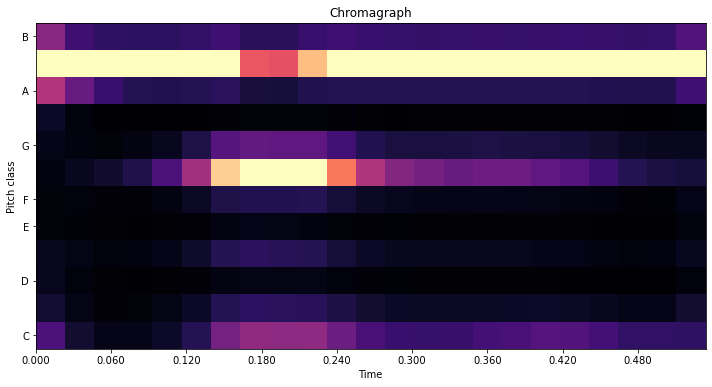

This chord is probably F#M 


In [53]:
c14 = x[int(50.15*SR):int(51.2*SR)]
printResults(c14, title = "Cø (C3 Gb3 Eb4 Bb4)") # without cut: C minor

F# is enharmonic to Gb, and the notes of a Gb major triad are:

Gb Bb Db

It seems like the C and Eb barely registered, so the algorithm just picked up on Gb and Bb, which is a Gb major triad without a fifth.

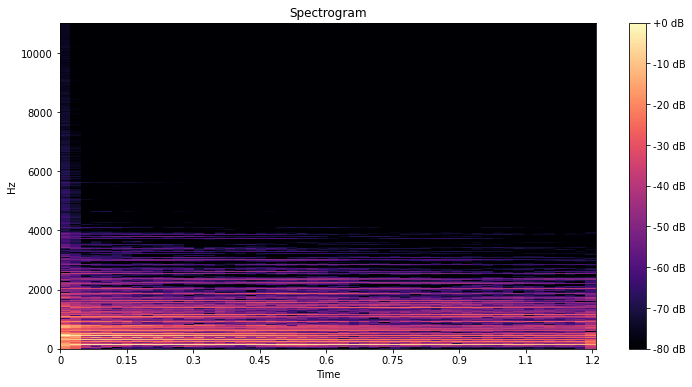

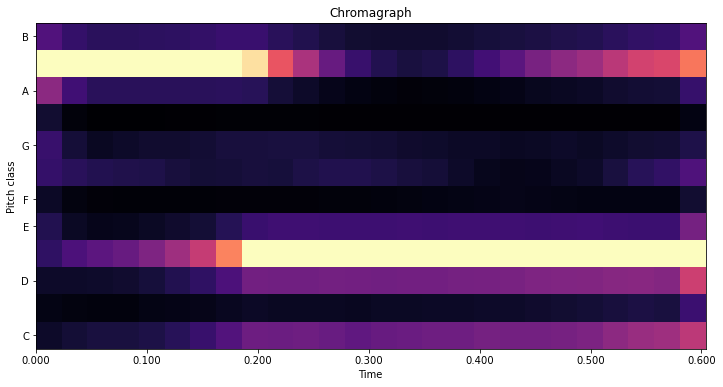

This chord is probably D#M 


In [59]:
c15 = x[int(53.2*SR):int(54.4*SR)]
printResults(c15, title = "Cø (C3 Eb3 Bb3 Gb4)")

Overlap notes between Cø and D#M/EbM: Eb, Bb

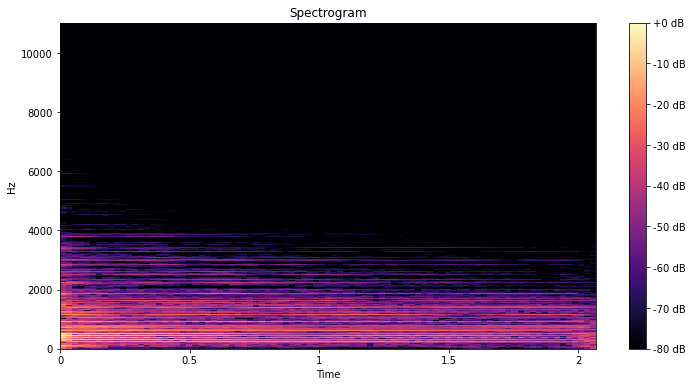

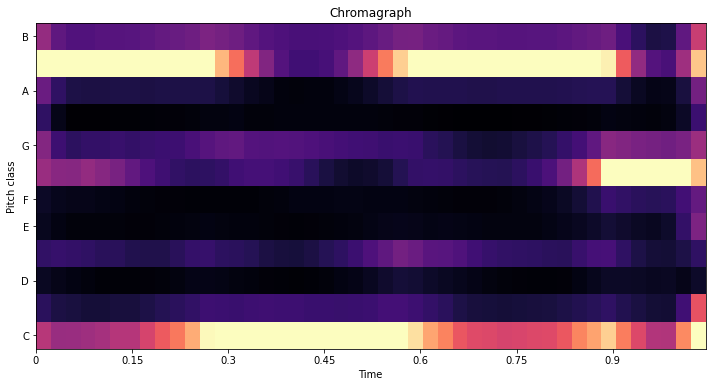

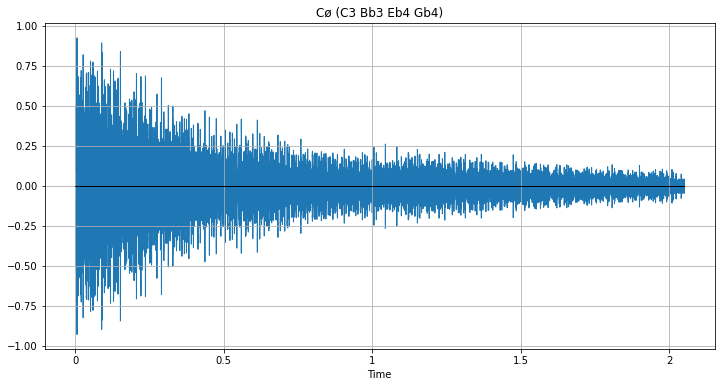

This chord is probably Chd


In [61]:
c16 = x[int(55.45*SR):int(57.5*SR)]
printResults(c16, title = "Cø (C3 Bb3 Eb4 Gb4)")

This was the only example that got the C half diminished chord correct! You can see in the chromagraphs that Gb ended up being brightest in this example, which would have made the diminished sound of the foundational triad more prominent.

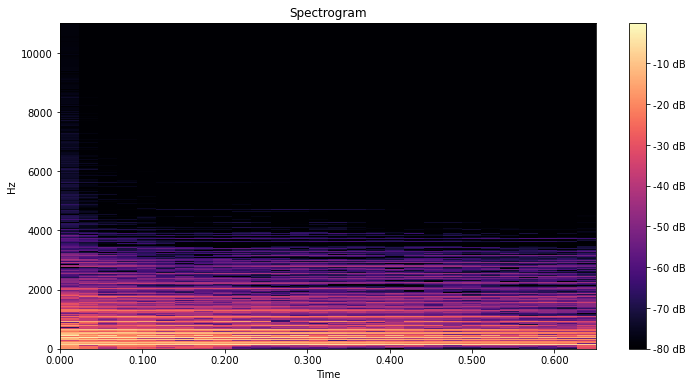

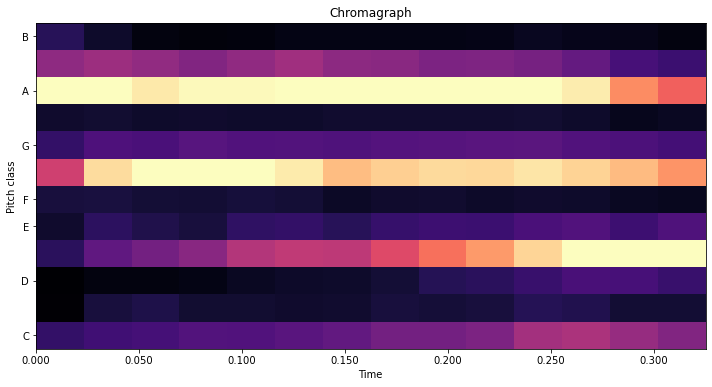

This chord is probably F#m 


In [66]:
c17 = x[int(58.65*SR):int(59.3*SR)]
printResults(c17, title = "C°7 (C3 Eb3 Gb3 Bbb3)")

The notes of an F# minor triad are:

F# A C#

or, spelled enharmonically for Gb:

Gb Bbb Db

So this seems like a similar issue to c14, except with Bbb instead of Bb as the overlapping note.

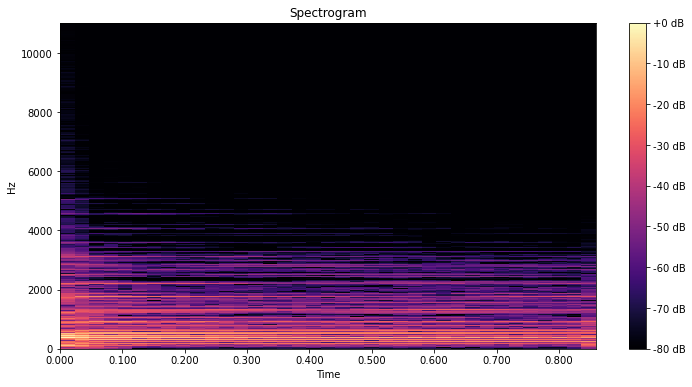

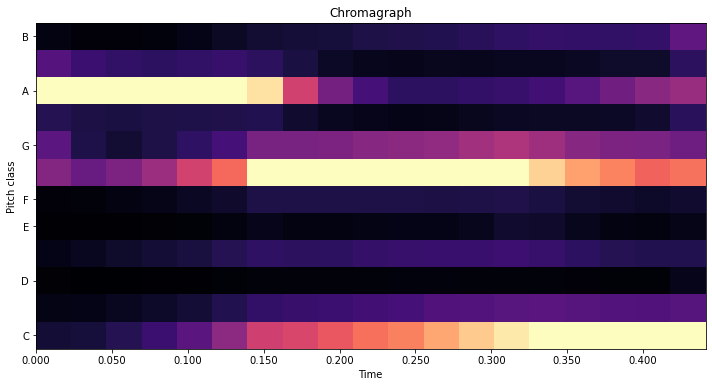

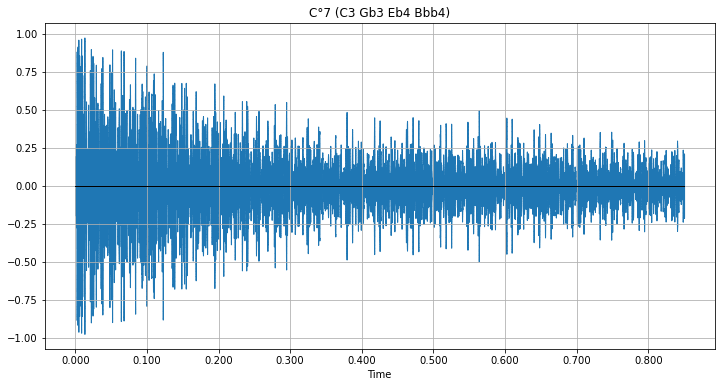

This chord is probably F#m 


In [74]:
c18 = x[int(64.85*SR):int(65.7*SR)]
printResults(c18, title = "C°7 (C3 Gb3 Eb4 Bbb4)")

Same issue twice in a row.

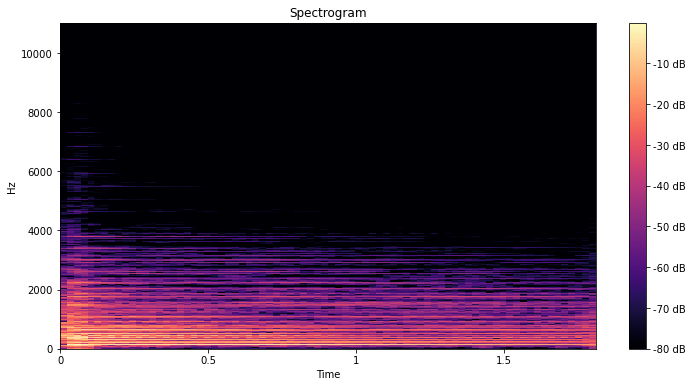

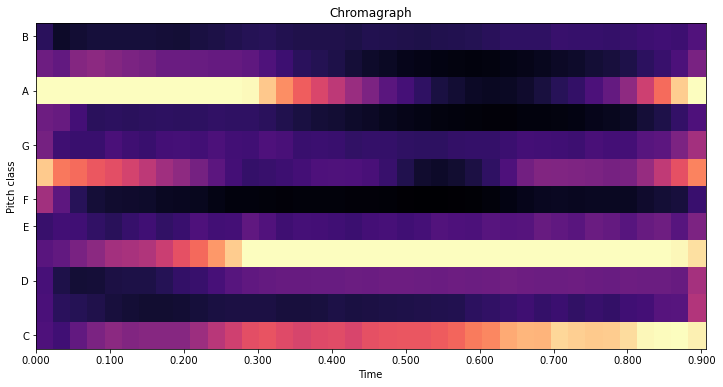

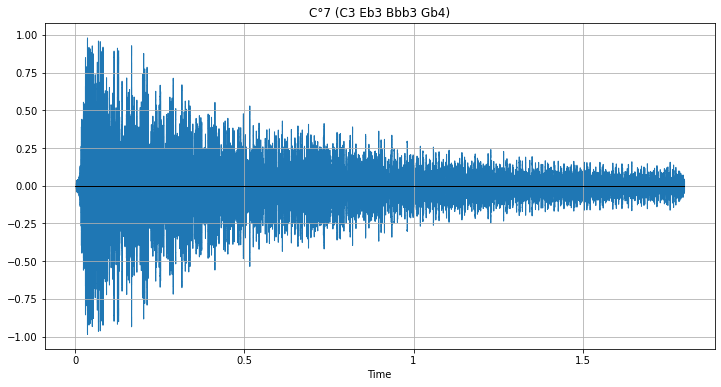

This chord is probably F#m 


In [76]:
c19 = x[int(67.1*SR):int(68.9*SR)]
printResults(c19, title = "C°7 (C3 Eb3 Bbb3 Gb4)")

Three times in a row!

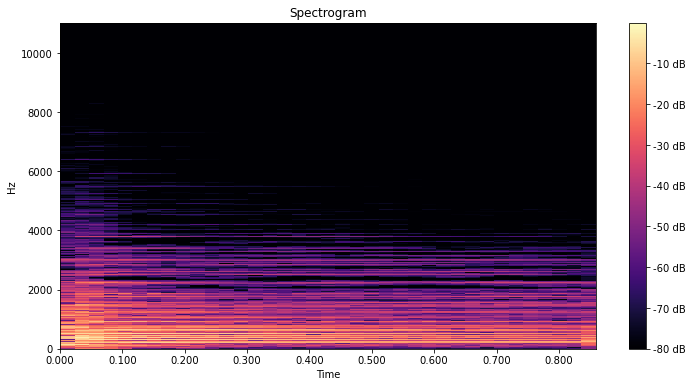

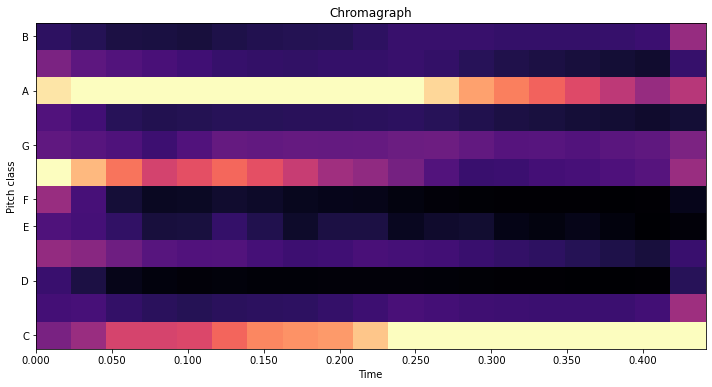

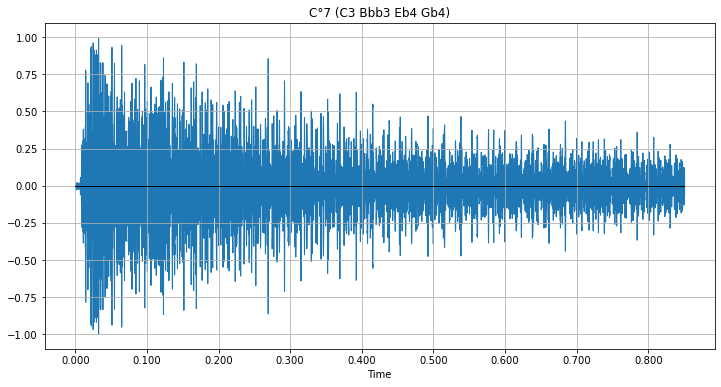

This chord is probably Cd 


In [78]:
c20 = x[int(69.35*SR):int(70.2*SR)]
printResults(c20, title = "C°7 (C3 Bbb3 Eb4 Gb4)")

Finally a correct result! Honestly, not sure why this example in particular registered as more C-diminished-y compared to the other ones.

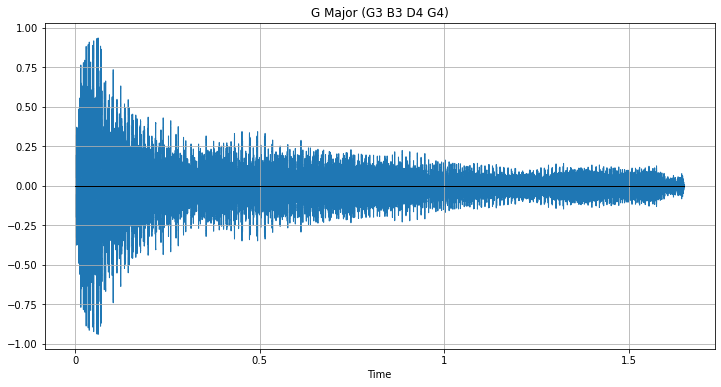

This chord is probably GM 


In [90]:
c21 = x[int(74.3*SR):int(75.95*SR)]
printResults(c21, title = "G Major (G3 B3 D4 G4)")

Between this and C major, it seems like the algorithm is pretty good with major chords.

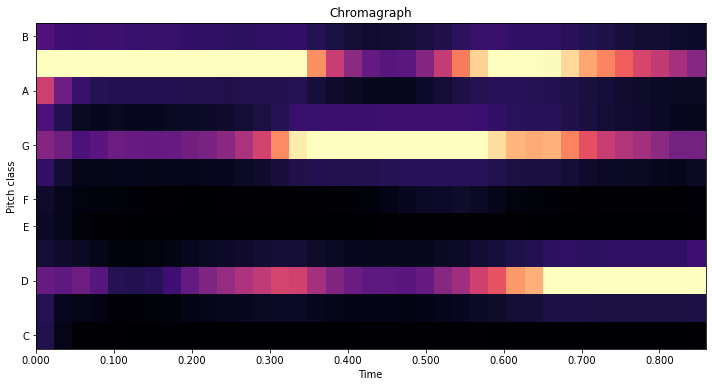

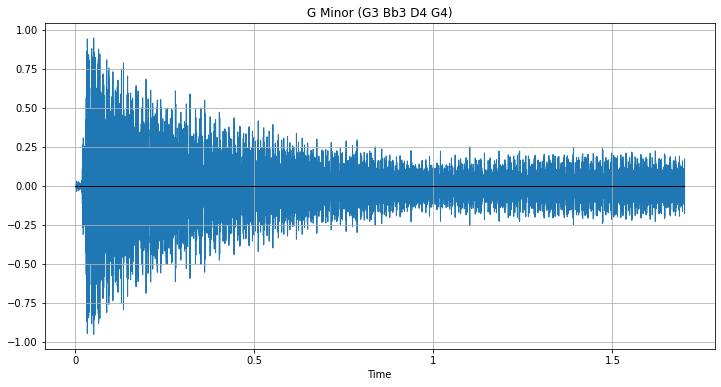

This chord is probably Gm 


In [91]:
c22 = x[int(76.3*SR):int(78*SR)]
printResults(c22, title = "G Minor (G3 Bb3 D4 G4)")

Also good with minor chords.

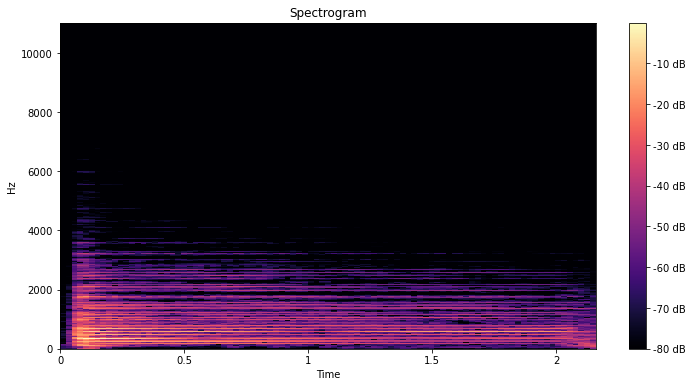

This chord is probably G7 


In [97]:
c23 = x[int(79.15*SR):int(81.3*SR)]
printResults(c23, title = "G7 (G3 B3 D4 F4)")


Again, no issue with dominant seventh chords.

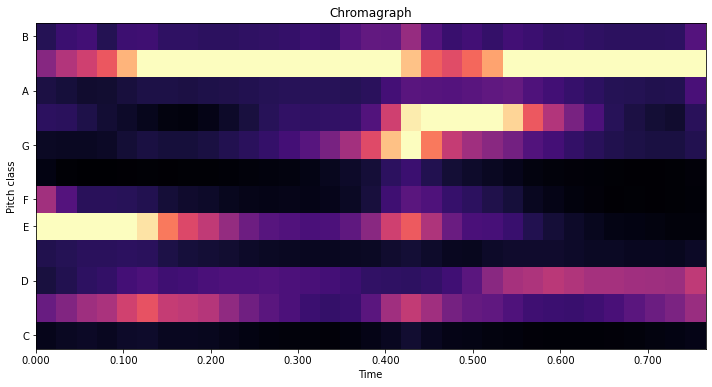

This chord is probably C#m 


In [103]:
c24 = x[int(85.2*SR):int(86.7*SR)]
printResults(c24, title = "G˚7 (G3 Bb3 Db4 Fb4)")

C# is enharmonic with Db, and a Db minor triad is spelled:

Db Fb Ab

It seems like the algorithm picked up on Db and Fb pretty strongly, but not Bb (which could have given us a Bb minor chord) or G (which would have given us the correct root and likely the correct chord as well)

In [120]:
c25 = x[int(91.35*SR):int(93.1*SR)]
printResults(c25, title = "B Major (B2 F#3 D#4 B4)")

This chord is probably BM 


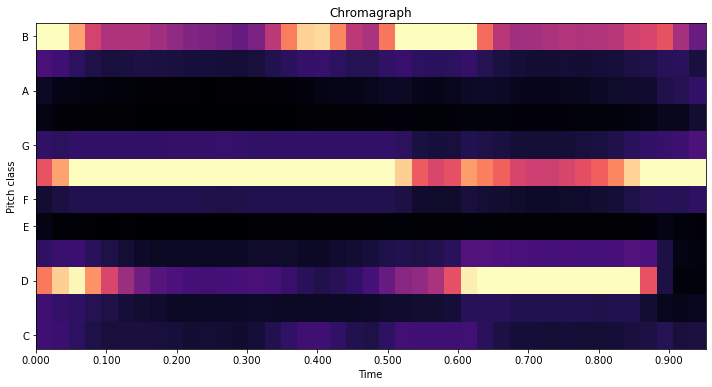

This chord is probably Bm 


In [111]:
c26 = x[int(94.65*SR):int(96.55*SR)]
printResults(c26, title = "B Minor (B2 F#3 D4 B4)")

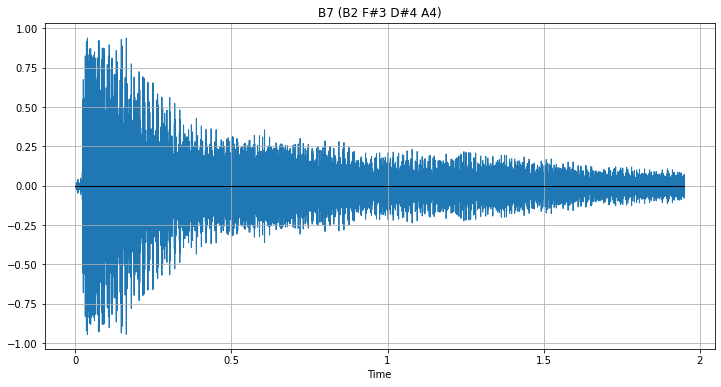

This chord is probably DM 


In [114]:
c27 = x[int(96.95*SR):int(98.9*SR)]
printResults(c27, title = "B7 (B2 F#3 D#4 A4)")

A D major triad is spelled:

D F# A

which shares considerable overlap with a B major dominant seventh chord. It seems like the only issue here was that the algorithm didn't pick up on the B, which is the root of the chord.
    

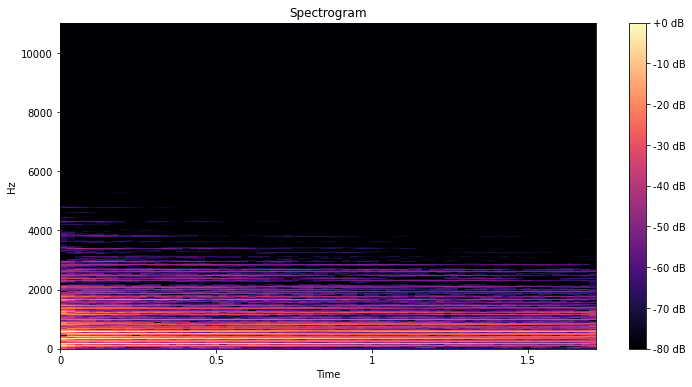

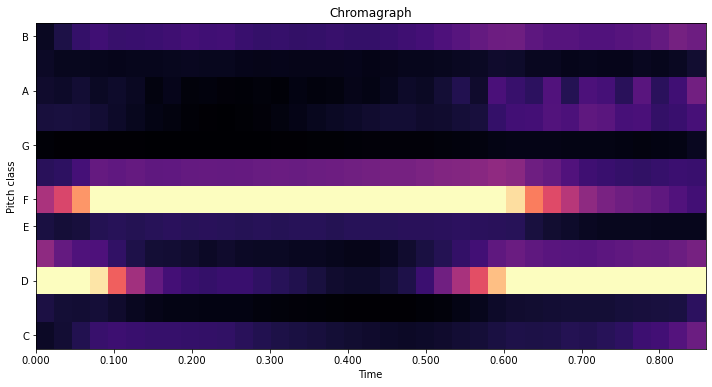

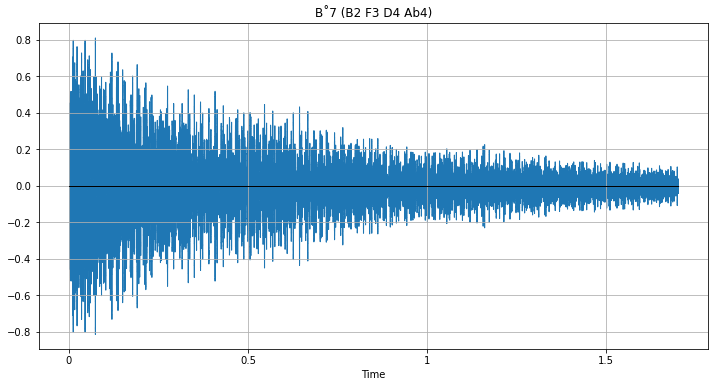

This chord is probably Dm 


In [119]:
c28 = x[int(100.3*SR):int(102*SR)]
printResults(c28, title = "B˚7 (B2 F3 D4 Ab4)")

Same issue as c27, but with F natural instead of F#.

Ok, time to see if we can put this to test with chords that change. Let's see what happens when we throw in these blocks of code from HW3:

In [129]:
def rectify(A):
    return np.maximum(A,np.zeros(len(A)))

# FFT
def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

# finds spectral distance
def spectral_distance(S,Sn,kind='L2'):      # default is L2 norm
    S = np.abs(S)          # just use magnitude of complex values
    Sn = np.abs(Sn)
    if(kind == 'L1'):
        return np.sum(np.abs(Sn-S))
    elif(kind == 'L2'):
        return (np.sum((Sn-S)**2))**0.5
    elif(kind == 'CD'):                     # Correlation Distance:  1 - correlation
        s = np.std(S)                       # must account for spectra with all 0's
        sn = np.std(Sn)
        if(np.isclose(s,0) or np.isclose(sn,0)):
            return 0.0
        else:
            return 1.0 - (((S - np.mean(S)) @ (Sn - np.mean(Sn))) / (len(S) * s * sn))
    elif(kind == 'RL1'):
        return np.sum(np.abs(rectify(Sn-S)))
    elif(kind == 'RL2'):
        return (np.sum(rectify(Sn-S)**2))**0.5               
    else:
        return None

# onset detection
def SpectralBasedOnsets(X,window_size=512,hop_length=256,
                        kind = None,     # distance function used, L1, L2, CD, SF1, SF2
                        filtr = None,    # filter applied before peak picking, if any, from ('MAF','sMAF','MF','sMF')
                        size = 3,        # size of kernel used in filter, if any
                        win = None,      # apply windowing function to window, if any ('hann','tri')
                        scale=None,      # scale factor for log, None = no log
                        height=None,     # these 3 parameters are for pick_peak,
                        prominence=None, # any not equal to None will be applied
                        distance=None,
                        displayAll=False):
    
    # Normalize amplitude of X so maximum is 1.0
    X = X / np.max(X)
    
    # windowing 
    if win!= None:
        win_size = len(X)
        if win == 'hann':
            X = X * windows.hann(win_size)
        else:
            X = X * windows.triang(win_size)
    
    X_energy = []           
    counter = 0
    while (counter <= (len(X) - window_size)):
        X_energy.append(realFFT(np.array(X[counter : counter + window_size])))
        counter += hop_length
    X_energy = np.array(X_energy) # array of arrays

    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Signal")
        plt.plot(X_energy)
        plt.show()

    # take the log with scaling factor:   np.log(1.0 + scale * X_energy)
    # if scale = None, do nothing

    if(scale == None):
        X_spectrogram = X_energy
    else:
        X_spectrogram = np.array([np.log(1.0 + scale * np.abs(k)) for k in X_energy])
    
    

    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Log X Energy Signal with scale factor "+str(scale))
        plt.plot(X_spectrogram)
        plt.show()

    # Calculate the novelty function (first difference) using np.diff(...)
    # Watch out:  np.diff(...) changes the array IN PLACE, so make a copy beforehand if you want
    # (debugging is easier if you have all the successive arrays)
    
    # Optional: add 0 at beginning before taking difference so have exactly the same number of values as X_energy
      
    num_windows = len(X_spectrogram)
    X_spectral_novelty = np.zeros(num_windows)

    for k in range(1,num_windows):           #first value will be 0, length unchanged
        X_spectral_novelty[k] = spectral_distance(X_spectrogram[k-1],X_spectrogram[k],kind)    
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Spectral Novelty")
        plt.plot(X_spectral_novelty)
        plt.show()
        
    # peak picking using parameters from the argument list: height, prominence, and distance
    X_energy_novelty_rectified = rectify(X_spectral_novelty)
    peaks,_ = find_peaks(X_energy_novelty_rectified,height=height,prominence=prominence,distance=distance)   
    
    if (displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Picking Peaks")
        plt.plot(peaks, X_energy_novelty_rectified[peaks], "or")
        plt.plot(X_energy_novelty_rectified)
        plt.show() 
    

    onsets = []  
    for window_index in peaks:
        onsets.append((window_index * hop_length) + int(window_size/2))
        
    onsets = np.array(onsets)
    
    if (displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Signal with Onsets")
        plt.plot(X)  
        for k in range(len(onsets)):
            plt.plot([onsets[k],onsets[k]],[-1,1],color='r')    
        plt.show()
    
    clicks = librosa.clicks(times=onsets/SR, sr=SR, hop_length=hop_length, length=len(X))
    
    return (onsets, clicks)

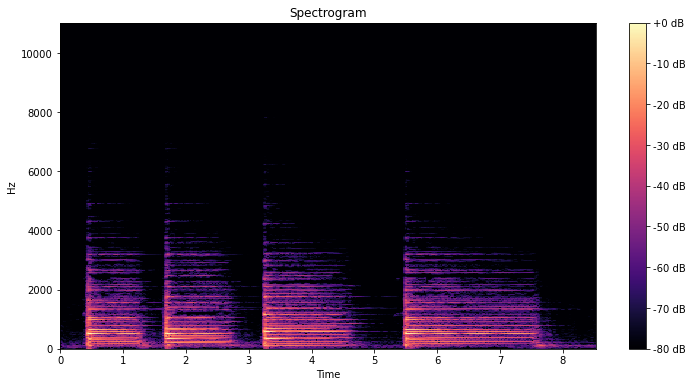

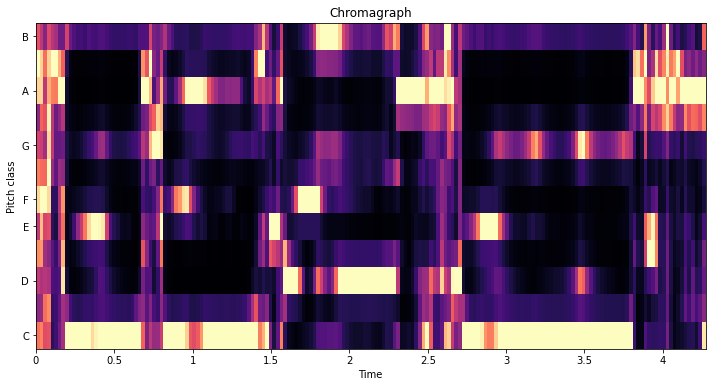

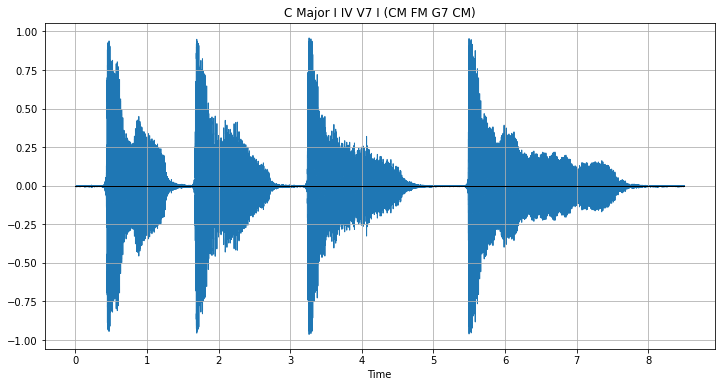

In [186]:
cp29 = x[int(141*SR):int(149.5*SR)]

displaySpectroChroma(x = cp29)

displaySignal(cp29, title="C Major I IV V7 I (CM FM G7 CM)")
display(Audio(cp29, rate=sr))


In [192]:
# using the chord templates like before, but now with successive chords
(onsets,_) = SpectralBasedOnsets(cp29,window_size=512,hop_length=256,
                                kind = 'L1',     # distance function used, L1, L2, CD, SF1, SF2
                                filtr = 'sMAF',    # filter applied before peak picking, if any
                                size = 3,        # size of kernel used in filter
                                win = None,      # apply windowing function to window
                                scale=10,      # scale factor for log, None = no log
                                height=10,     # these 3 parameters are for pick_peak,
                                prominence=0.3, #    any not equal to None will be applied
                                distance=100,
                                displayAll=False)
def find_chords(signal, onsets, offset, chord_length):
    onsets_ = onsets + (offset*SR) 
    for onset in onsets_:
        (chord, _) = apply_chord_templates(get_chroma(signal[int(onset) : int(onset+(chord_length*SR))]),dist="L1", display = False)
        print(chord, end="") 

find_chords(cp29, onsets, 0.2, 0.4)




CM FM A#M CM 

Since this project isn't focused on beat recognition, we changed these parameters manually to get the correct-ish onsets. Knowing what we know from all the above examples, noise right before the chord messes with the algorithm, so we had it jump to the middle of the chord using <i>offset</i>. We also used <i>chord_length</i> to cut noise after the chord. 

Now, no matter how much we adjusted <i>find_chords</i>, the third chord was always wrong; it should be G7, but kept registering as Bb major; this is because their shared notes are D and F. It might be because it was played in an inversion, where the bass note was overshadowed. If we had a comb filter for the bass, it might be able to solve this problem?

Let's try it again with another chord progression:

In [187]:
cp30 = x[int(150*SR):int(156.5*SR)]

displaySpectroChroma(x = cp30)

displaySignal(cp30, title="G Major I IV V7 I (GM CM D7 GM)")
Audio(cp30, rate=sr)

In [193]:
(onsets,_) = SpectralBasedOnsets(cp30,window_size=512,hop_length=256,
                                kind = 'L1',     # distance function used, L1, L2, CD, SF1, SF2
                                filtr = 'sMAF',    # filter applied before peak picking, if any
                                size = 3,        # size of kernel used in filter
                                win = None,      # apply windowing function to window
                                scale=10,      # scale factor for log, None = no log
                                height=10,     # these 3 parameters are for pick_peak,
                                prominence=0.3, #    any not equal to None will be applied
                                distance=100,
                                displayAll=False)
def find_chords(signal, onsets, offset, chord_length):
    onsets_ = onsets + (offset*SR) 
    for onset in onsets_:
        (chord, _) = apply_chord_templates(get_chroma(signal[int(onset) : int(onset+(chord_length*SR))]),dist="L1", display = False)
        print(chord, end="") 

find_chords(cp30, onsets, 0.2, 0.3)

GM CM DM GM 

Much closer this time! It just missed the 7th in D7, but it's pretty much correct besides that. Now let's see what happens with more complicated music!